In [1]:
import sqlite3
import pandas as pd
import pandas.io.sql as pd_sql
import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime as dt
from datetime import timedelta
%matplotlib inline


#### Importing data from SQLite database in pandas

In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')

In [3]:
query = "SELECT * FROM fires;"

fire_df = pd_sql.read_sql(query, conn)

In [4]:
fire_df.shape

(1880465, 39)

In [5]:
fire_df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Initial Data Cleaning and EDA

Removing features that are not important/useful

In [6]:
fire_clean_df = fire_df.drop(['FIRE_CODE','FIRE_NAME','FIPS_CODE','FIPS_NAME','Shape','OBJECTID','FPA_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM',
              'NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID','NWCG_REPORTING_UNIT_NAME',
              'SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',
              'LOCAL_INCIDENT_ID','ICS_209_INCIDENT_NUMBER','ICS_209_NAME','MTBS_ID','MTBS_FIRE_NAME',
              'COMPLEX_NAME','COUNTY','FOD_ID','OWNER_CODE','OWNER_DESCR'],axis = 1).copy()

In [7]:
fire_clean_df.shape

(1880465, 14)

In [8]:
fire_clean_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,CA
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,CA
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,CA
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,CA
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,CA


##### Converting Discovery and Containment Date to datetime 

In [9]:
fire_clean_df.DISCOVERY_DATE = pd.to_datetime(fire_clean_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fire_clean_df.CONT_DATE = pd.to_datetime(fire_clean_df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')


##### And removing records that have 'Misc/Missing/Undefined' Cause

In [10]:
#Creating a subset df that has only Misc and Missing/Undefined fire causes
fire_misc_df = fire_clean_df[(fire_clean_df.STAT_CAUSE_DESCR == 'Miscellaneous') | (fire_clean_df.STAT_CAUSE_DESCR == 'Missing/Undefined')].copy()

In [11]:
fire_misc_df.to_pickle("./fire_misc.pkl")

In [12]:
#Removing Misc and Missing from the dataframe before classification
fire_clean_df = fire_clean_df[~((fire_clean_df.STAT_CAUSE_DESCR == 'Miscellaneous') | (fire_clean_df.STAT_CAUSE_DESCR == 'Missing/Undefined'))]

In [13]:
fire_clean_df.shape

(1389937, 14)

In [44]:
fire_clean_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,A,38.933056,-120.404444,CA
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,A,38.984167,-120.735556,CA
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,A,38.559167,-119.913333,CA
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,A,38.559167,-119.933056,CA
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,A,38.635278,-120.103611,CA


#### Initial EDA

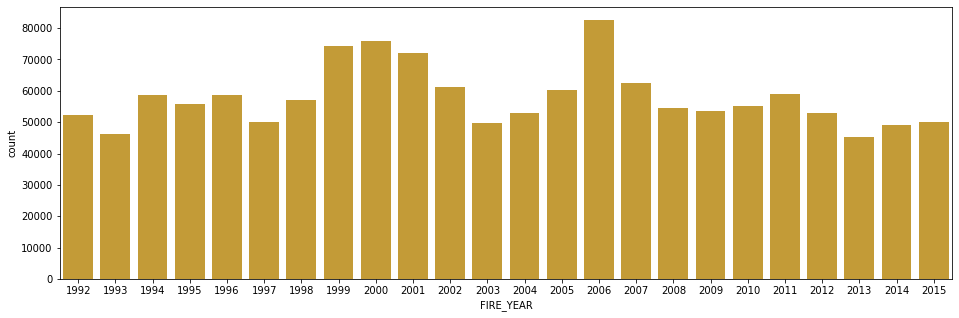

In [14]:
plt.figure(figsize = (16,5))
sns.countplot(x = 'FIRE_YEAR', data = fire_clean_df, color = 'goldenrod');

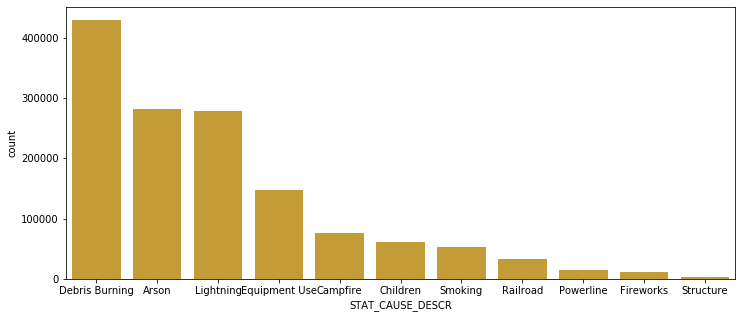

In [15]:
plt.figure(figsize=(12,5))
sns.countplot(x = 'STAT_CAUSE_DESCR', data = fire_clean_df , 
              order = fire_clean_df.STAT_CAUSE_DESCR.value_counts().index
              , color= 'goldenrod');

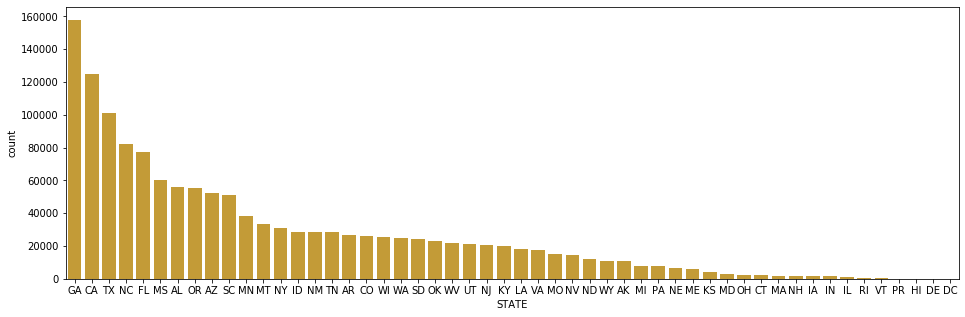

In [16]:
plt.figure(figsize=(16,5))
sns.countplot(x = 'STATE', data = fire_clean_df, 
              order = fire_clean_df.STATE.value_counts().index ,color = 'goldenrod');

In [43]:
fire_clean_df.isnull().sum()

FIRE_YEAR                0
DISCOVERY_DATE           0
DISCOVERY_DOY            0
DISCOVERY_TIME      612699
STAT_CAUSE_CODE          0
STAT_CAUSE_DESCR         0
CONT_DATE           635717
CONT_DOY            635717
CONT_TIME           678061
FIRE_SIZE                0
FIRE_SIZE_CLASS          0
LATITUDE                 0
LONGITUDE                0
STATE                    0
dtype: int64

In [78]:
fire_clean_df.FIRE_SIZE_CLASS.value_counts()

B    700505
A    479610
C    169619
D     21017
E     10299
F      5783
G      3104
Name: FIRE_SIZE_CLASS, dtype: int64

In [58]:
fire_clean_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,A,38.933056,-120.404444,CA
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,A,38.984167,-120.735556,CA
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,A,38.559167,-119.913333,CA
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,A,38.559167,-119.933056,CA
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,A,38.635278,-120.103611,CA


##### Creating a label with 2 categories - Natural (contains lightning) or Human Activity (all others) from the stat cause description

In [17]:
def label(cause_desc):
    if cause_desc == 'Lightning' :
        label = 0
    else:
        label = 1
    return label

In [90]:
fire_clean_model_df = fire_clean_df.copy()

In [91]:
fire_clean_model_df['CAUSE_LABEL'] = fire_clean_model_df.STAT_CAUSE_DESCR.apply(label)

In [92]:
fire_clean_model_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,CAUSE_LABEL
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,A,38.933056,-120.404444,CA,0
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,A,38.984167,-120.735556,CA,1
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,A,38.559167,-119.913333,CA,0
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,A,38.559167,-119.933056,CA,0
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,A,38.635278,-120.103611,CA,0


In [55]:
fire_clean_model_df.shape

(1389937, 15)

In [56]:
fire_clean_model_df.CAUSE_LABEL.value_counts()

1    1111469
0     278468
Name: CAUSE_LABEL, dtype: int64

#### Create dummies for State column

In [93]:
state_dummy = pd.get_dummies(fire_clean_model_df.STATE)

In [94]:
fire_clean_model_df = pd.concat([fire_clean_model_df, state_dummy], axis =1)

In [95]:
fire_clean_model_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,...,0,0,0,0,0,0,0,0,0,0
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,...,0,0,0,0,0,0,0,0,0,0
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,...,0,0,0,0,0,0,0,0,0,0
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,...,0,0,0,0,0,0,0,0,0,0
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,...,0,0,0,0,0,0,0,0,0,0


/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


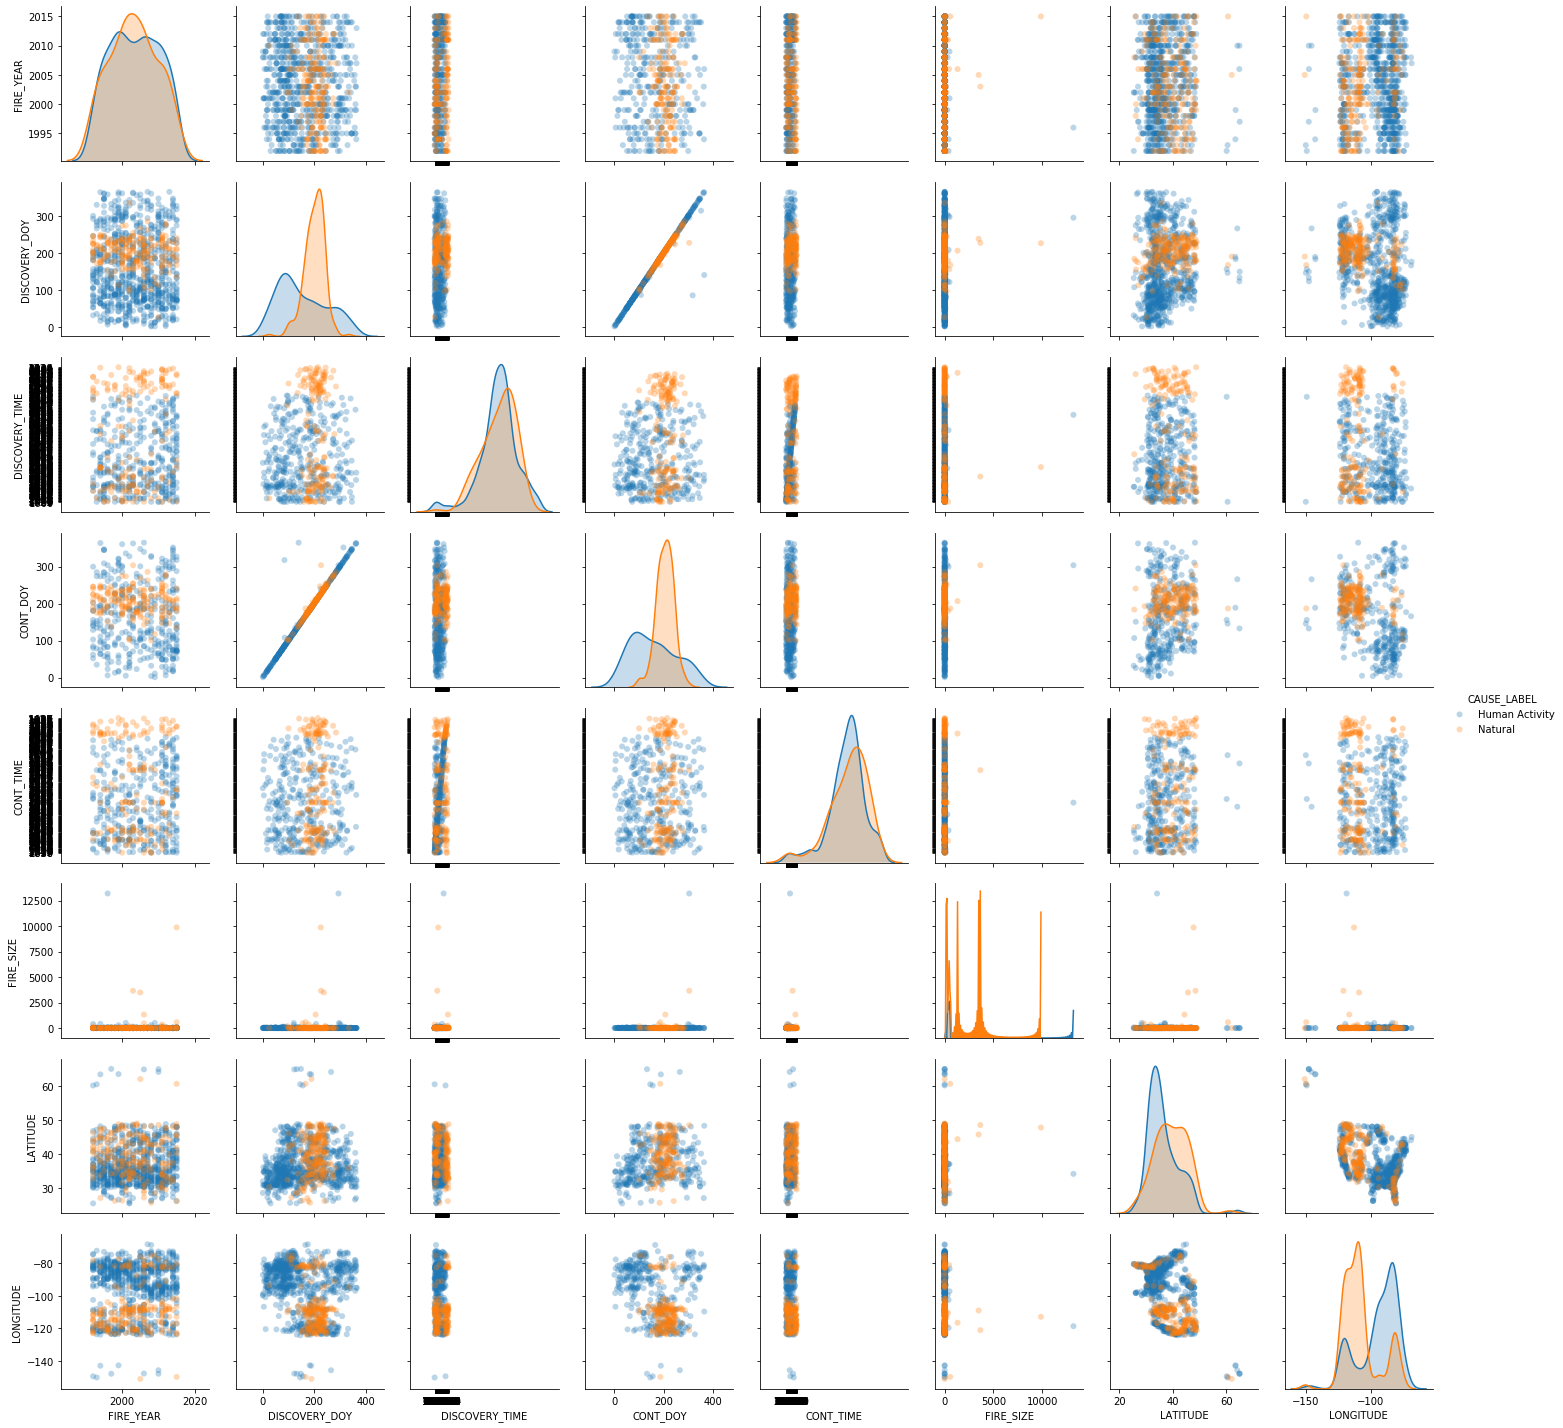

In [64]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['STAT_CAUSE_CODE','STAT_CAUSE_DESCR'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='CAUSE_LABEL', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(fire_clean_model_df)

In [96]:
#columns to drop - FIRE_SIZE_CLASS [STATE, LATITUDE, LONGITUDE to be dropped later]

fire_clean_model_df = fire_clean_model_df.drop(['FIRE_SIZE_CLASS'], axis = 1)

#### Create Containment Duration field from Discovery date time and Cont Date time
##### Disc and Cont TIME are missing for almost 50% of the data -- so we will look at the Discovery Date and Cont Date to see if the fire was contained on the same day or it took multiple days to control

In [97]:
fire_clean_model_df['DAYS_TO_CONT'] = (fire_clean_model_df.CONT_DATE - 
                                       fire_clean_model_df.DISCOVERY_DATE).fillna(timedelta(days=1)).apply(lambda x:
                                                                                                           int(x.days))

In [98]:
fire_clean_model_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,DAYS_TO_CONT
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,...,0,0,0,0,0,0,0,0,0,0
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,...,0,0,0,0,0,0,0,0,0,0
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,...,0,0,0,0,0,0,0,0,0,5
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,...,0,0,0,0,0,0,0,0,0,5
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,...,0,0,0,0,0,0,0,0,0,1


In [108]:
#Now that we have days to contain feature, we can drop Discovery Date, time and CONT date time
#drop containment day of year - we have discovery doy and days to contain.

fire_clean_model_df = fire_clean_model_df.drop(['DISCOVERY_DATE','DISCOVERY_TIME','CONT_DATE','CONT_TIME',
                                                'CONT_DOY'], 
                                               axis = 1)


In [27]:
# # Encoding the CAUSE LABEL to ints

# le = preprocessing.LabelEncoder()
# # fire_clean_df['CAUSE_LABEL'] = le.fit_transform(fire_clean_df['CAUSE_LABEL'])
# fire_clean_df['STATE'] = le.fit_transform(fire_clean_df['STATE'])
# fire_clean_df['FIRE_SIZE_CLASS'] = le.fit_transform(fire_clean_df['FIRE_SIZE_CLASS'])

# fire_clean_df['DISCOVERY_TIME'] = pd.to_numeric(fire_clean_df['DISCOVERY_TIME'])
# fire_clean_df['CONT_TIME'] = pd.to_numeric(fire_clean_df['CONT_TIME'])

In [69]:
fire_clean_model_df[fire_clean_model_df.DAYS_TO_CONT == fire_clean_model_df.DAYS_TO_CONT.max()]

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,CAUSE_LABEL,AK,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,DAYS_TO_CONT
1146209,1998,255,4.0,Campfire,0.01,44.32935,-122.92779,OR,1,0,...,0,0,0,0,0,0,0,0,0,4018


#### Looking at the outlier above, we look at all the "number of days to contain" - dropping anything that took more than 6 months to contain (seems like a data entry error)

In [70]:
fire_clean_model_df[fire_clean_model_df.DAYS_TO_CONT > 180].groupby(fire_clean_model_df.STAT_CAUSE_DESCR).count()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,CAUSE_LABEL,AK,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,DAYS_TO_CONT
STAT_CAUSE_DESCR,,,,,,,,,,,,,,,,,,,,,
Arson,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
Campfire,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Children,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Debris Burning,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
Equipment Use,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
Lightning,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
Powerline,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Railroad,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Smoking,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


In [99]:
fire_clean_model_df = fire_clean_model_df[fire_clean_model_df.DAYS_TO_CONT < 180]

In [100]:
fire_clean_model_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,DAYS_TO_CONT
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,...,0,0,0,0,0,0,0,0,0,0
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,...,0,0,0,0,0,0,0,0,0,0
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,...,0,0,0,0,0,0,0,0,0,5
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,...,0,0,0,0,0,0,0,0,0,5
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,...,0,0,0,0,0,0,0,0,0,1


In [73]:
fire_clean_model_df.columns

Index(['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR',
       'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STATE', 'CAUSE_LABEL', 'AK',
       'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY', 'DAYS_TO_CONT'],
      dtype='object')

#### Convert discovery day of year to discovery season

In [101]:
def season(doy) :
# spring = range(80, 172)
# summer = range(172, 264)
# fall = range(264, 355)
    if doy in range(80,172):
        return 'spring'
    elif doy in range(173,264):
        return 'summer'
    elif doy in range(265,355):
        return 'fall'
    else:
        return 'winter'
    

In [102]:
# Convert Discovery DOY to season categorical feature
# geography - use lat long <only in xgboost>

fire_clean_model_df['SEASON'] = fire_clean_model_df.DISCOVERY_DOY.apply(season)


In [103]:
#Convert season column to dummies

season_dummy = pd.get_dummies(fire_clean_model_df.SEASON)
fire_clean_model_df = pd.concat([fire_clean_model_df, season_dummy], axis =1)

In [104]:
fire_clean_model_df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,...,WA,WI,WV,WY,DAYS_TO_CONT,SEASON,fall,spring,summer,winter
1,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,...,0,0,0,0,0,spring,0,1,0,0
2,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,...,0,0,0,0,0,spring,0,1,0,0
3,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,...,0,0,0,0,5,summer,0,0,1,0
4,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,...,0,0,0,0,5,summer,0,0,1,0
5,2004,2004-06-30,182,1800,1.0,Lightning,2004-07-01,183.0,1600,0.10,...,0,0,0,0,1,summer,0,0,1,0


In [105]:
fire_clean_model_df.columns

Index(['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY',
       'CONT_TIME', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STATE',
       'CAUSE_LABEL', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE',
       'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD',
       'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'DAYS_TO_CONT', 'SEASON',
       'fall', 'spring', 'summer', 'winter'],
      dtype='object')

##### Making a copy and saving to use in Tableau

In [106]:
df_save = fire_clean_model_df.copy()

In [119]:
df_save.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,CAUSE_LABEL,DAYS_TO_CONT,SEASON
1,2004,2004-05-12,133,1.0,Lightning,0.25,38.933056,-120.404444,CA,0,0,spring
2,2004,2004-05-31,152,5.0,Debris Burning,0.10,38.984167,-120.735556,CA,1,0,spring
3,2004,2004-06-28,180,1.0,Lightning,0.10,38.559167,-119.913333,CA,0,5,summer
4,2004,2004-06-28,180,1.0,Lightning,0.10,38.559167,-119.933056,CA,0,5,summer
5,2004,2004-06-30,182,1.0,Lightning,0.10,38.635278,-120.103611,CA,0,1,summer


In [120]:
df_save.shape

(1389698, 12)

#### Final cleaning and pickling to use in the models notebook

In [109]:
fire_clean_model_df = fire_clean_model_df.drop(['FIRE_YEAR','STAT_CAUSE_CODE','STAT_CAUSE_DESCR'], 
                                               axis = 1)

In [110]:
fire_clean_model_df.head()

,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,CAUSE_LABEL,AK,AL,AR,AZ,...,WA,WI,WV,WY,DAYS_TO_CONT,SEASON,fall,spring,summer,winter
1,133,0.25,38.933056,-120.404444,CA,0,0,0,0,0,...,0,0,0,0,0,spring,0,1,0,0
2,152,0.10,38.984167,-120.735556,CA,1,0,0,0,0,...,0,0,0,0,0,spring,0,1,0,0
3,180,0.10,38.559167,-119.913333,CA,0,0,0,0,0,...,0,0,0,0,5,summer,0,0,1,0
4,180,0.10,38.559167,-119.933056,CA,0,0,0,0,0,...,0,0,0,0,5,summer,0,0,1,0
5,182,0.10,38.635278,-120.103611,CA,0,0,0,0,0,...,0,0,0,0,1,summer,0,0,1,0


In [80]:
fire_clean_model_df.to_pickle("./fire_clean_model.pkl")

In [111]:
fire_clean_model_df.corr()

,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,CAUSE_LABEL,AK,AL,AR,AZ,CA,...,VT,WA,WI,WV,WY,DAYS_TO_CONT,fall,spring,summer,winter
DISCOVERY_DOY,1.000000,0.007278,0.132798,-0.252239,-0.206275,0.004332,-0.040688,-0.000148,0.046853,0.129249,...,-0.005534,0.056950,-0.026724,-0.014031,0.036858,0.032927,0.627550,-0.338682,0.383374,-0.582446
FIRE_SIZE,0.007278,1.000000,0.049107,-0.047819,-0.041603,0.092713,-0.005254,-0.003457,0.000116,-0.001247,...,-0.000450,0.003359,-0.004071,-0.002650,0.003549,0.230867,-0.008449,-0.002117,0.018628,-0.011672
LATITUDE,0.132798,0.049107,1.000000,-0.473119,-0.204461,0.390654,-0.149338,-0.053674,-0.091427,0.036760,...,0.018237,0.244423,0.183293,0.029675,0.093570,0.117430,-0.072794,0.065590,0.238358,-0.281553
LONGITUDE,-0.252239,-0.047819,-0.473119,1.000000,0.395471,-0.298361,0.117017,0.026478,-0.194263,-0.489555,...,0.022350,-0.209390,0.051498,0.117880,-0.069062,-0.109997,0.076250,0.154576,-0.445919,0.269468
CAUSE_LABEL,-0.206275,-0.041603,-0.204461,0.395471,1.000000,-0.041067,0.090481,0.042576,-0.171997,-0.012312,...,0.006556,-0.063526,0.059668,0.059043,-0.086442,-0.143277,0.152025,0.153042,-0.480607,0.247126
AK,0.004332,0.092713,0.390654,-0.298361,-0.041067,1.000000,-0.017943,-0.012239,-0.017358,-0.027531,...,-0.001333,-0.011842,-0.012029,-0.011005,-0.007815,0.131563,-0.031405,0.043183,0.018610,-0.042685
AL,-0.040688,-0.005254,-0.149338,0.117017,0.090481,-0.017943,1.000000,-0.028635,-0.040611,-0.064412,...,-0.003119,-0.027706,-0.028144,-0.025747,-0.018284,-0.017308,0.025618,-0.018786,-0.070250,0.078899
AR,-0.000148,-0.003457,-0.053674,0.026478,0.042576,-0.012239,-0.028635,1.000000,-0.027701,-0.043935,...,-0.002128,-0.018898,-0.019197,-0.017562,-0.012471,-0.009293,0.015905,-0.028526,-0.007970,0.027349
AZ,0.046853,0.000116,-0.091427,-0.194263,-0.171997,-0.017358,-0.040611,-0.027701,1.000000,-0.062311,...,-0.003017,-0.026802,-0.027226,-0.024907,-0.017688,0.005514,-0.044352,-0.005144,0.111103,-0.082948
CA,0.129249,-0.001247,0.036760,-0.489555,-0.012312,-0.027531,-0.064412,-0.043935,-0.062311,1.000000,...,-0.004786,-0.042510,-0.043182,-0.039504,-0.028054,-0.003987,0.013398,-0.050947,0.150813,-0.125338


In [39]:
# def plot_features(df, sample_size=500):
    
#     sample = (df.sample(1000, random_state=44)) 
#     sns.pairplot(sample,hue='CAUSE_LABEL', plot_kws=dict(alpha=.3, edgecolor='none'))

# plot_features(fire_clean_model_df)

In [82]:
fire_clean_model_df.CAUSE_LABEL.value_counts()

1    1111308
0     278390
Name: CAUSE_LABEL, dtype: int64